In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle
from astropy.units import Quantity
from scipy.stats import poisson, norm, chi2
from histpy import Histogram, Axis

from gammaraytoys import ToyCodedMaskDetector2D, poisson_binned_log_likelihood, unbinned_log_likelihood, richardson_lucy

In [2]:
det = ToyCodedMaskDetector2D.create_random_mask( mask_size = 40 * u.cm, 
                                           mask_npix = 130, 
                                           mask_separation = 100 * u.cm, 
                                           open_fraction = .5, 
                                           detector_size = 22 * u.cm, 
                                           detector_npix = 440, 
                                           detector_efficiency = 0.65)

(<AxesSubplot: xlabel='off_axis_angle [deg]', ylabel='[cm]'>,
 <ErrorbarContainer object of 3 artists>)

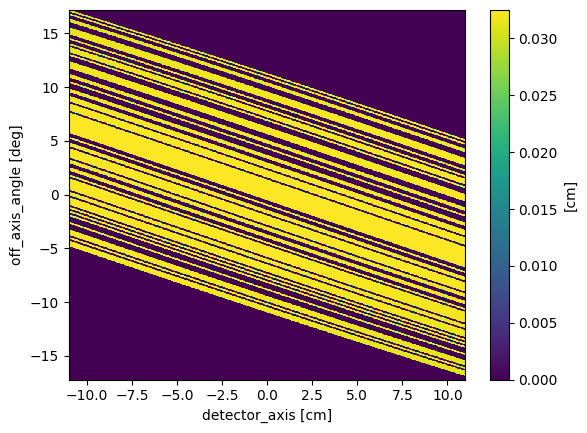

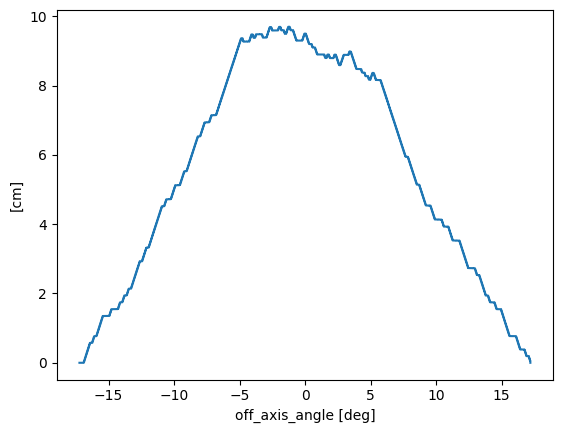

In [3]:
# Slow the first time
det.response.plot()
det.response.project('off_axis_angle').plot()

In [4]:
det.partially_coded_fov.to(u.deg) * 2

<Quantity 34.44687238 deg>

In [5]:
det.angular_resolution.to(u.arcmin)

<Quantity 10.57764899 arcmin>

## PSRExtended and multiple sources

Text(0, 0.5, 'y [cm]')

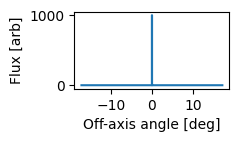

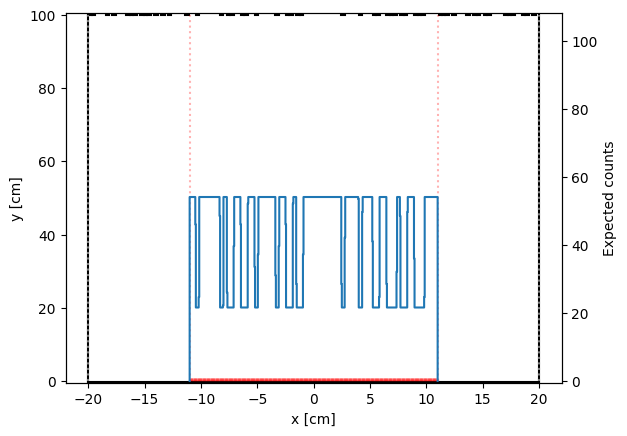

In [6]:
fluctuate = False

source_flux = 1e3 / u.cm / u.s # total
duration = 1*u.s
source_loc = 0*det.angular_resolution # Shift for multiple sources
source_width = 0*det.angular_resolution
nsources = 1
snr = 1

# Inject
model_in = None
for x0 in np.linspace(-det.fully_coded_fov, det.fully_coded_fov, nsources+2)[1:-1] + source_loc:
    
    source_model = det.gaussian_model(source_flux / nsources, x0, source_width)

    if model_in is None:
        model_in = source_model
    else:
        model_in += source_model

# Plot
fig,ax = plt.subplots(figsize = [2,1])

model_in.plot(ax)
ax.set_xlabel("Off-axis angle [deg]")
ax.set_ylabel("Flux [arb]")

# Plot
data = det.convolve_model(model_in, duration = duration)

bkg = det.uniform_bkg(rate = snr * source_flux * det.effective_area(source_loc), 
                      duration = duration)

data += bkg

if fluctuate:
    data[:] = poisson.rvs(mu = data.contents)

ax = det.plot(data = data, angle = source_loc)

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')

(0.0, 1.1)

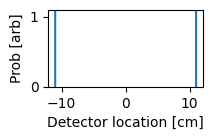

In [7]:
fig,ax = plt.subplots(figsize = [2,1])
bkg.plot(ax)
ax.set_xlabel("Detector location [cm]")
ax.set_ylabel("Prob [arb]")
ax.set_ylim(0,1.1)

## RL

In [8]:
model = Histogram(det.sky_axis, unit = 1/u.cm/u.s)
model[:] = 1*model.unit

bkg_norm = 1

In [9]:
response_aux = (det.response.contents * duration).to_value(1/model.unit)

if bkg_norm is not None:
    response_aux = np.append(response_aux, bkg.contents[:,None], axis = 1)

In [10]:
model_aux = model.contents.value

if bkg_norm is not None:
    model_aux = np.append(model_aux, bkg_norm)

print(np.sum(model_aux))

model_aux = richardson_lucy(data.contents, model_aux, response_aux, niter = 100)

print(np.sum(model_aux))

if bkg_norm is not None:
    bkg_norm = model_aux[-1]
    model_aux = model_aux[:-1]

model = Histogram(model.axis, contents = model_aux * model.unit)

977.0
1985.0912270511005


bkg_norm = 0.5491934170051105


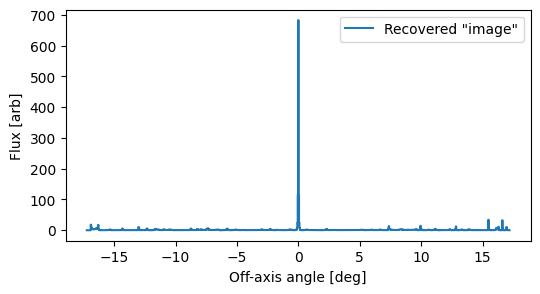

In [11]:
print(f"bkg_norm = {bkg_norm}")

fig,ax = plt.subplots(figsize = [6,3])

model.plot(ax, label = 'Recovered "image"')
#model_in.plot(ax, ls = "--", label = "Injected model")

ax.set_xlabel("Off-axis angle [deg]")
ax.set_ylabel("Flux [arb]")

ax.legend(loc = 'upper right')

## Likelihood

In [12]:
ts_values = np.zeros(11)

In [13]:
flux_in = 3e2 / u.cm / u.s
duration = 1*u.s
nangres = 3
ext_in = nangres*det.angular_resolution
snr = 1

model = det.gaussian_model(1/u.cm/u.s, 0*u.deg, 0*u.deg) # Aux

bkg = det.uniform_bkg(rate = snr * flux_in * det.effective_area(0*u.deg), 
                      duration = duration)

def get_gaussian_expectation(flux, ext, bkg_norm, fluctuate = False):

    model = det.gaussian_model(flux, 0*u.deg, ext)

    data = det.convolve_model(model, duration = duration, fluctuate = False)

    data += bkg * bkg_norm
    
    if fluctuate:
        data[:] = poisson.rvs(mu = data.contents)
    
    return data


data = get_gaussian_expectation(flux_in, ext_in, 1)

In [14]:
hyp = Histogram([np.geomspace(.1*flux_in, 10*flux_in, 20), 
                 np.arange(0, 2, det.angular_resolution.to_value(u.deg)/2)*u.deg,
                 np.linspace(0, snr + 3, 30)],
                 axis_scale = ['log', 'linear', 'linear'],
                 labels = ['flux','ext', 'bkg_norm'])

log_like = Histogram(hyp.axes)
log_like0 = Histogram(hyp.axes)

for nbkg,bkg_norm_hyp in enumerate(hyp.axes['bkg_norm'].centers):

    print(nbkg)
    
    expectation0 = get_gaussian_expectation(0/u.cm/u.s, 0*u.deg, bkg_norm_hyp)

    log_like0_i = poisson_binned_log_likelihood(data, expectation0)

    log_like0[{'flux':slice(None),'ext':slice(None),'bkg_norm':nbkg}] = log_like0_i

    for nflux,flux_hyp in enumerate(hyp.axes['flux'].centers):
        for next,ext_hyp in enumerate(hyp.axes['ext'].centers):
    
                expectation = get_gaussian_expectation(flux_hyp, ext_hyp, bkg_norm_hyp)
                
                log_like_i = poisson_binned_log_likelihood(data, expectation)
    
                log_like[{'flux':nflux,'ext':next,'bkg_norm':nbkg}] = log_like_i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


(<AxesSubplot: xlabel='detector_axis [cm]'>,
 <ErrorbarContainer object of 3 artists>)

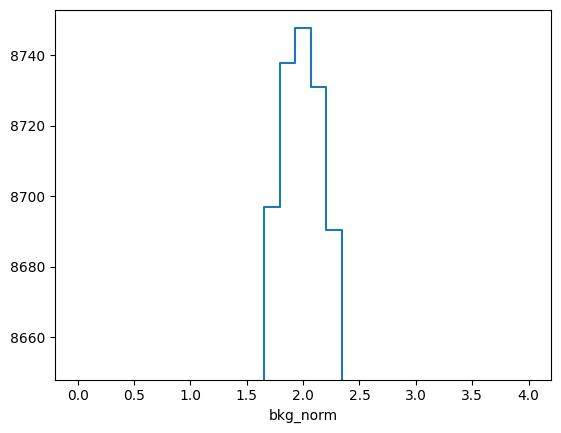

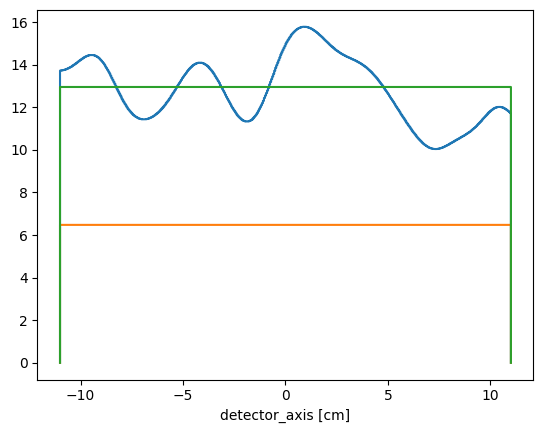

In [15]:
log_like0_bkg = log_like0.slice[0,0].project('bkg_norm')

ax,_ = log_like0_bkg.plot()
ax.set_ylim(np.max(log_like0_bkg) - 100, np.max(log_like0_bkg) + 5)

ax,_ = data.plot()
get_gaussian_expectation(0/u.cm/u.s, 0*u.deg, 1).plot(ax)
get_gaussian_expectation(0/u.cm/u.s, 0*u.deg, 
                         log_like0_bkg.axis.centers[np.argmax(log_like0_bkg)]).plot(ax)

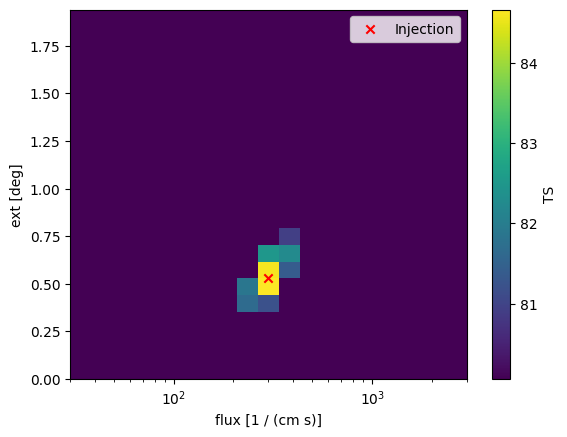

In [16]:
margin_log_like0 = Histogram(log_like0.axes['flux','ext'],
                             contents = np.max(log_like0.contents,
                                               axis = log_like0.axes.label_to_index('bkg_norm')))

margin_log_like = Histogram(log_like.axes['flux','ext'],
                            contents = np.max(log_like.contents,
                                              axis = log_like.axes.label_to_index('bkg_norm')))

ts = 2*(margin_log_like - margin_log_like0)

ts_values[nangres] = np.max(ts)

vmin = 0
vmin = np.max(ts) - chi2.isf(.1, 2)
ax,_ = ts.plot(vmin = vmin)

ax.get_figure().axes[-1].set_ylabel("TS")

ax.scatter([flux_in.to_value(1/u.cm/u.s)],[ext_in.to_value(u.deg)], color = 'red', marker = 'x', 
           label = 'Injection')

ax.legend()

Text(0.5, 0, 'Source extension / angular resolution')

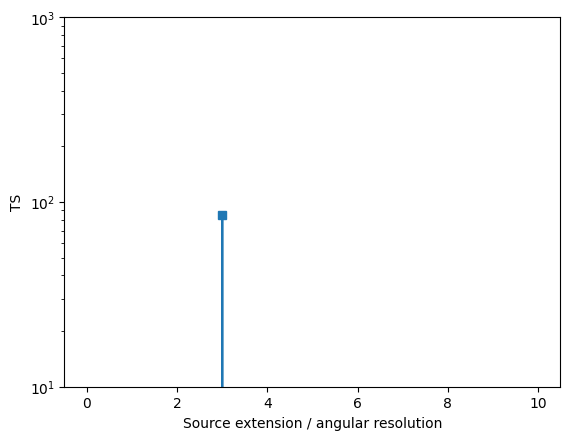

In [17]:
fig,ax = plt.subplots()

ax.plot(ts_values, marker = 's')

ax.set_ylim(10, 1000)

ax.set_yscale('log')

ax.set_ylabel("TS")
ax.set_xlabel("Source extension / angular resolution")

(<matplotlib.image.AxesImage at 0x1308c9fd0>, <Mollview: >)

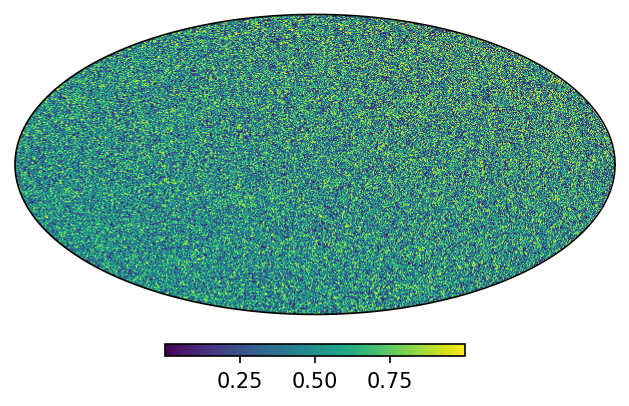

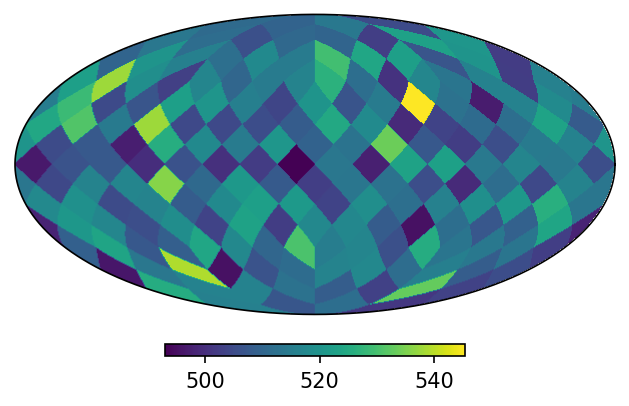

In [9]:
from mhealpy import HealpixMap
import numpy as np

m = HealpixMap(nside = 128, scheme = 'ring')

m[:] = np.random.uniform(size = m.npix)

m.plot()

m.rasterize(nside = 4, scheme = 'ring').plot()